In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
from importlib import reload


Text(0, 0.5, '$N$')

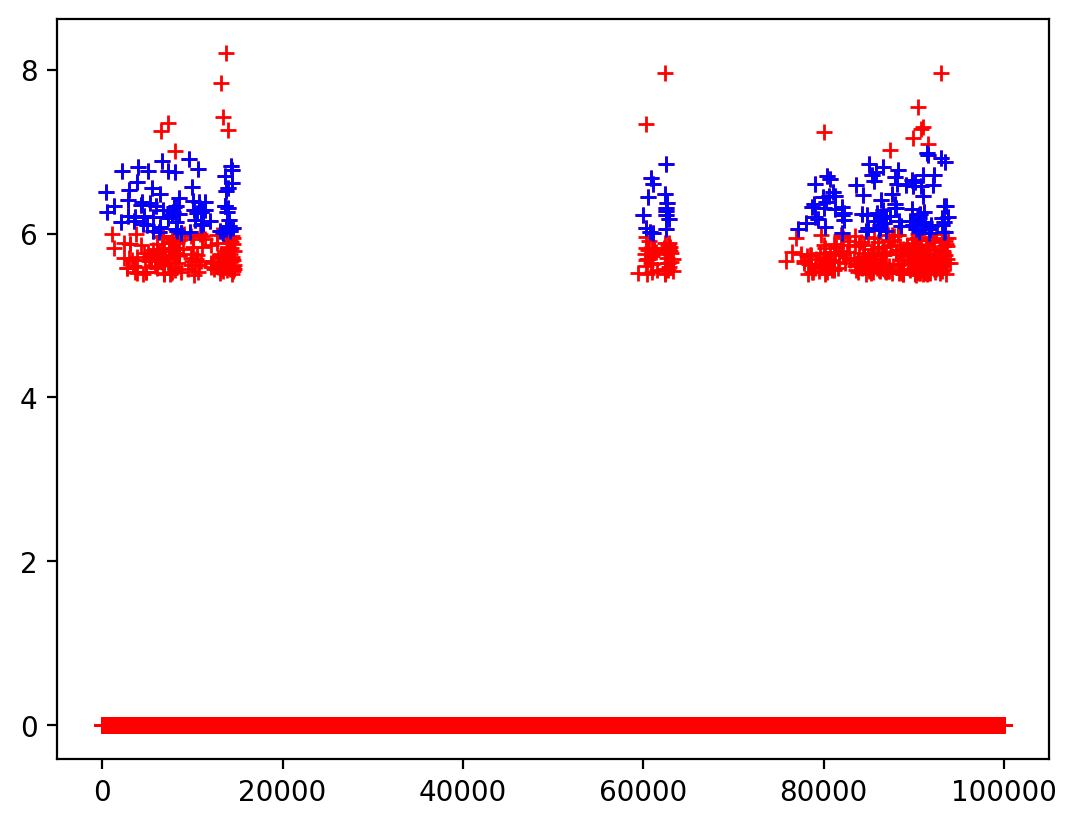

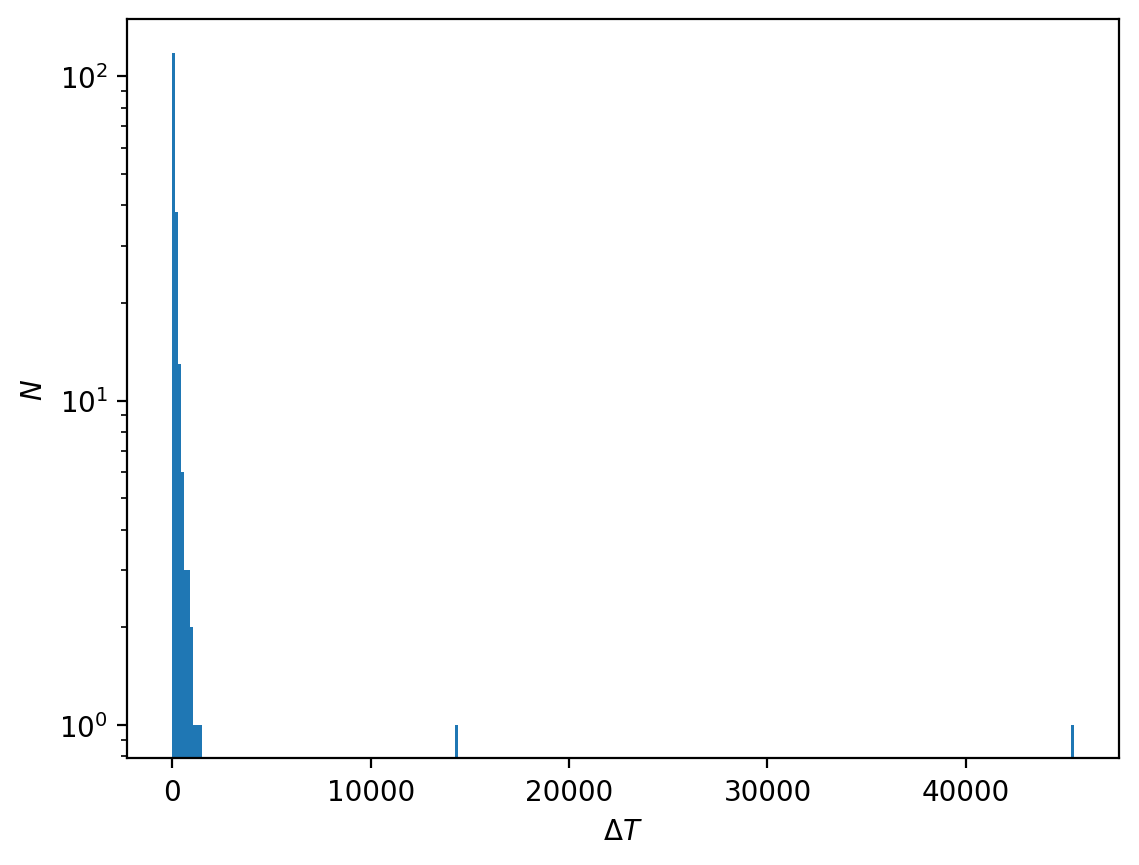

In [38]:
def get_most_recent_output_folder_name():
    most_recent_output_folder_name = sorted(glob.glob("./runs/*"))[-1]
    return most_recent_output_folder_name


most_recent_output_folder_name = get_most_recent_output_folder_name()
time_series = pickle.load(
    open(most_recent_output_folder_name + "/time_series.pickle", "rb")
)

plt.plot(time_series.time, time_series.event_magnitude, "r+")
lower_indices = np.where(time_series.event_magnitude >= 6.0)
upper_indices = np.where(time_series.event_magnitude < 7.0)
a = np.intersect1d(lower_indices, upper_indices)
plt.plot(time_series.time[a], time_series.event_magnitude[a], "b+")


# Calculate interevent times
plt.figure()
plt.hist(np.diff(time_series.time[a]), 300, log=True)
plt.xlabel("$\Delta T$")
plt.ylabel("$N$")




<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

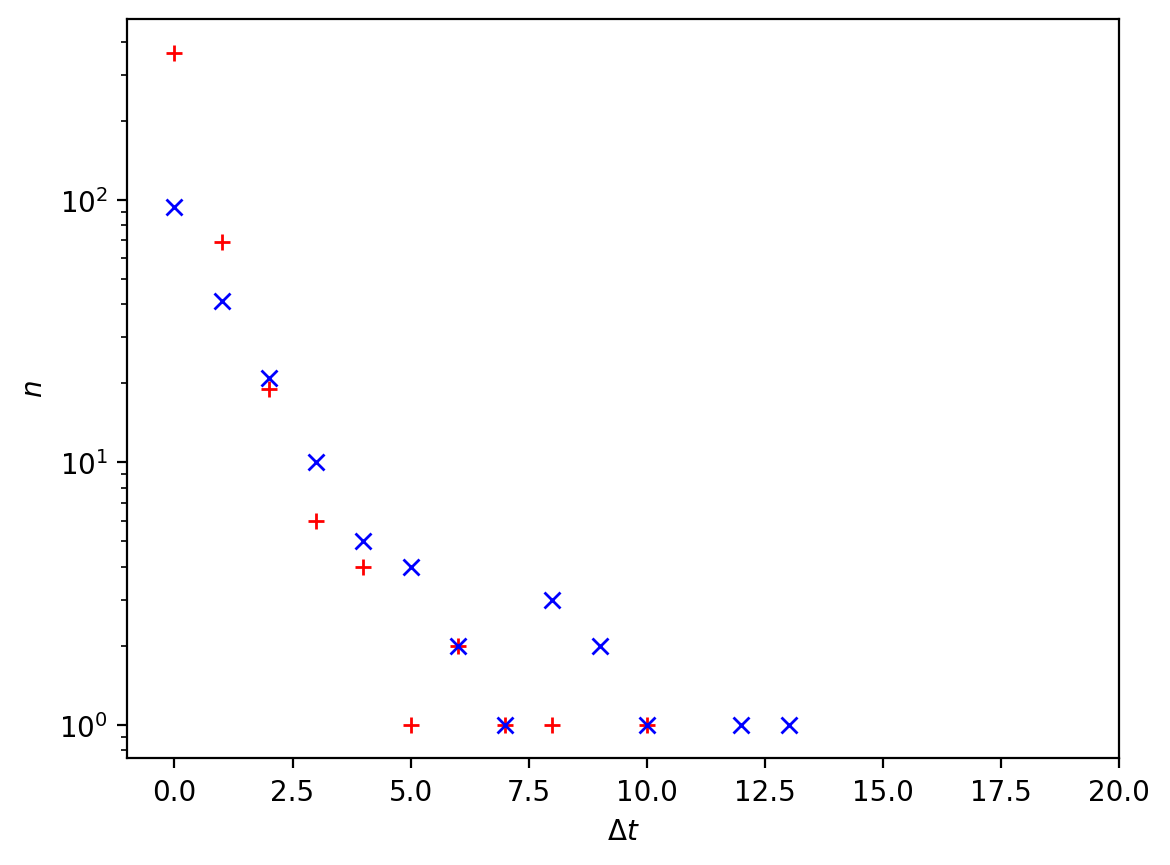

In [59]:
delta_t_bins = np.linspace(0, 10000, 100)
magnitude_bins = np.array([5.5, 6.0, 6.5, 7.0, 7.5, 8.0])

# bins = 10
lower_indices = np.where(time_series.event_magnitude >= 5.5)
upper_indices = np.where(time_series.event_magnitude < 6.0)
a = np.intersect1d(lower_indices, upper_indices)
counts_a, binEdges = np.histogram(np.diff(time_series.time[a]), bins=delta_t_bins)
plt.figure()
# plt.plot(time_series.time[a], time_series.event_magnitude[a], "b+")
# plt.title(f"{len(a)=}")


lower_indices = np.where(time_series.event_magnitude >= 6.0)
upper_indices = np.where(time_series.event_magnitude < 7.0)
b = np.intersect1d(lower_indices, upper_indices)
counts_b, binEdges = np.histogram(np.diff(time_series.time[b]), bins=delta_t_bins)
plt.figure()
# plt.plot(time_series.time[b], time_series.event_magnitude[b], "b+")
# plt.title(f"{len(b)=}")


# counts, binEdges = np.histogram(np.diff(time_series.time[a]), bins=300)
plt.figure()
plt.semilogy(counts_a, "r+")
plt.semilogy(counts_b, "bx")

plt.xlim([-1, 20])
plt.xlabel("$\Delta t$")
plt.ylabel("$n$")
plt.show()